## Arbeitsschritte
* Daten laden +
* EDA +
* Cleaning +
* Feature Engineering
* Modelle bauen (ML und NN)
* Hyperparam. tuning für besten Modelle
* Ensemble für Modelle
* Feature Importance / Permutation Importance
* Submission auf kaggle (+ Screenshot)
* 2 geile Grafiken
* je Kapitel eine Zusammenfassung

Siehe itslearning Aufgabe

# Mies viele Kommentare

# Daten Import

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from best_params import make
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
import torch
import torch.nn as nn
import json

df = pd.read_csv("train.csv")
store_df = pd.read_csv("store.csv")

big_df = df.merge(store_df, on="Store", how="left")
store_df

C:\Users\pasca\AppData\Local\Temp\ipykernel_19000\3900345087.py:18: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("train.csv")


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## EDA

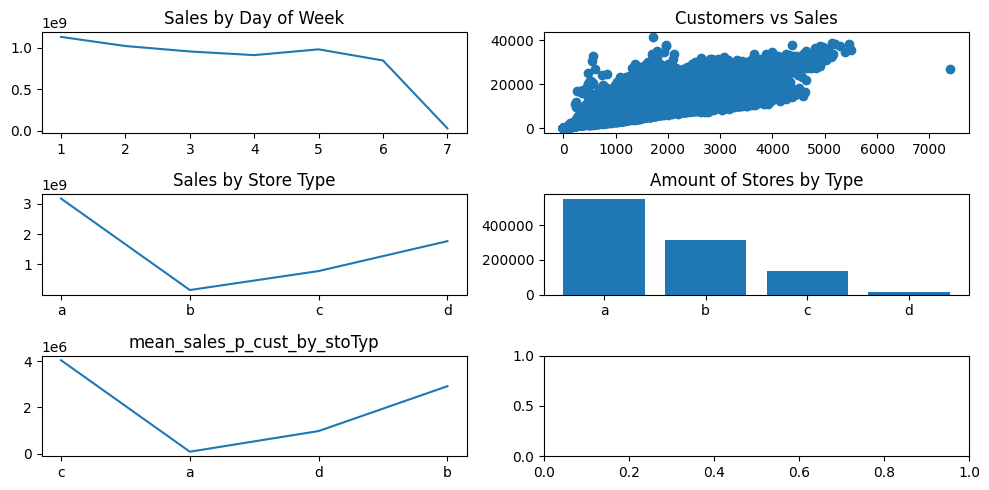

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(10, 5))

# Plot 1: Sales by Day of Week
s_b_d = big_df["Sales"].groupby(big_df["DayOfWeek"]).sum()
axs[0, 0].plot(s_b_d)
axs[0, 0].set_title('Sales by Day of Week')

# Plot 2: Scatter plot of Customers vs Sales
axs[0, 1].scatter(big_df["Customers"], big_df["Sales"])
axs[0, 1].set_title('Customers vs Sales')

# Plot 3: Sales by Store Type
sales_by_storeType = big_df["Sales"].groupby(big_df["StoreType"]).sum()
axs[1, 0].plot(sales_by_storeType)
axs[1, 0].set_title('Sales by Store Type')

# Plot 4: Amount of Stores by Type
amt_stores_by_type = big_df["StoreType"].value_counts()
axs[1, 1].bar(["a", "b", "c", "d"], amt_stores_by_type)
axs[1, 1].set_title('Amount of Stores by Type')

# mean sales per customer
sales_per_customer = big_df["Sales"] / big_df["Customers"]
big_df["sales_per_customer"] = sales_per_customer

m_sales_customer_by_st = big_df["sales_per_customer"].groupby(big_df["StoreType"]).sum().values.tolist()
axs[2, 0].plot(big_df["StoreType"].unique(), m_sales_customer_by_st)
axs[2, 0].set_title("mean_sales_p_cust_by_stoTyp")

# Display the plots
plt.tight_layout()
plt.show()

## Datacleaning

In [15]:
big_df["CompetitionDistance"] = big_df["CompetitionDistance"].fillna(0)

comp_zeros = big_df["CompetitionDistance"] == 0

big_df["CompetitionOpenSinceMonth"][comp_zeros] = 0
big_df["CompetitionOpenSinceYear"][comp_zeros] = 0

big_df = big_df.dropna(axis=0)
big_df.head(5)

C:\Users\pasca\AppData\Local\Temp\ipykernel_19000\2838521340.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  big_df["CompetitionOpenSinceMonth"][comp_zeros] = 0
C:\Users\pasca\AppData\Local\Temp\ipykernel_19000\2838521340.py:5: SettingWi

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,sales_per_customer
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",10.126675
10,11,5,2015-07-31,10457,1236,1,1,0,1,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct",8.460356
13,14,5,2015-07-31,6544,710,1,1,0,1,a,a,1300.0,3.0,2014.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct",9.216901
14,15,5,2015-07-31,9191,766,1,1,0,1,d,c,4110.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",11.998695


## Feature Engineering

In [16]:
#big_df["year"] = big_df["Date"].str.split("-").str[0].astype(int)
#big_df["month"] = big_df["Date"].str.split("-").str[1].astype(int)
#big_df["day"] = big_df["Date"].str.split("-").str[2].astype(int)

to_drop = ["Date", "Store"]

big_df = big_df.drop(to_drop, axis=1)

big_df["CompetitionDistance"] = big_df["CompetitionDistance"].astype(int)
big_df["CompetitionOpenSinceMonth"] = big_df["CompetitionOpenSinceMonth"].astype(int)
big_df["CompetitionOpenSinceYear"] = big_df["CompetitionOpenSinceYear"].astype(int)

big_df["Promo2SinceWeek"] = big_df["Promo2SinceWeek"].astype(int)
big_df["Promo2SinceYear"] = big_df["Promo2SinceYear"].astype(int)

#big_df["promo2week_bool"] = big_df["Promo2SinceWeek"] == big_df["Promo2SinceWeek"].isna()

store_type_dict = {"a": 0, "b": 1, "c": 2, "d": 3}
big_df["StoreType"] = big_df["StoreType"].map(store_type_dict)

assortment_dict = {"a": 0, "b": 1, "c": 2}
big_df["Assortment"] = big_df["Assortment"].map(assortment_dict)

big_df

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,sales_per_customer
1,5,6064,625,1,1,0,1,0,0,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",9.702400
2,5,8314,821,1,1,0,1,0,0,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",10.126675
10,5,10457,1236,1,1,0,1,0,2,960,11,2011,1,1,2012,"Jan,Apr,Jul,Oct",8.460356
13,5,6544,710,1,1,0,1,0,0,1300,3,2014,1,40,2011,"Jan,Apr,Jul,Oct",9.216901
14,5,9191,766,1,1,0,1,3,2,4110,3,2010,1,14,2011,"Jan,Apr,Jul,Oct",11.998695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016084,3,2814,361,1,0,0,1,2,2,330,11,2008,1,5,2013,"Feb,May,Aug,Nov",7.795014
1016085,3,5099,620,1,0,0,1,0,2,5330,9,2011,1,31,2013,"Jan,Apr,Jul,Oct",8.224194
1016086,3,3955,525,1,0,0,1,0,0,1400,6,2012,1,13,2010,"Jan,Apr,Jul,Oct",7.533333
1016088,3,4576,444,1,0,0,1,2,0,3490,4,2011,1,22,2012,"Jan,Apr,Jul,Oct",10.306306


In [17]:
print(big_df["PromoInterval"].unique()) # im 3-Monats Intervall

['Jan,Apr,Jul,Oct' 'Mar,Jun,Sept,Dec' 'Feb,May,Aug,Nov']


In [18]:
#big_df["first_promo_month"] = big_df["PromoInterval"].str.split(",").str[0]

big_df["jan"] = 0
big_df["feb"] = 0
big_df["mar"] = 0
big_df["apr"] = 0
big_df["may"] = 0
big_df["jun"] = 0
big_df["jul"] = 0
big_df["aug"] = 0
big_df["sep"] = 0
big_df["oct"] = 0
big_df["nov"] = 0
big_df["dec"] = 0

for index, row in big_df.iterrows():
    start = row["PromoInterval"].split(",")[0]
    match start:
        case "Jan":
            big_df.at[index, "jan"] = 1
            big_df.at[index, "apr"] = 1
            big_df.at[index, "jul"] = 1
            big_df.at[index, "oct"] = 1

        case "Feb":
            big_df.at[index, "feb"] = 1
            big_df.at[index, "may"] = 1
            big_df.at[index, "aug"] = 1
            big_df.at[index, "nov"] = 1

        case "Mar":
            big_df.at[index, "mar"] = 1
            big_df.at[index, "jun"] = 1
            big_df.at[index, "sep"] = 1
            big_df.at[index, "dec"] = 1


big_df = big_df.drop("PromoInterval", axis=1)
big_df


,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
1,5,6064,625,1,1,0,1,0,0,570,...,0,1,0,0,1,0,0,1,0,0
2,5,8314,821,1,1,0,1,0,0,14130,...,0,1,0,0,1,0,0,1,0,0
10,5,10457,1236,1,1,0,1,0,2,960,...,0,1,0,0,1,0,0,1,0,0
13,5,6544,710,1,1,0,1,0,0,1300,...,0,1,0,0,1,0,0,1,0,0
14,5,9191,766,1,1,0,1,3,2,4110,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016084,3,2814,361,1,0,0,1,2,2,330,...,0,0,1,0,0,1,0,0,1,0
1016085,3,5099,620,1,0,0,1,0,2,5330,...,0,1,0,0,1,0,0,1,0,0
1016086,3,3955,525,1,0,0,1,0,0,1400,...,0,1,0,0,1,0,0,1,0,0
1016088,3,4576,444,1,0,0,1,2,0,3490,...,0,1,0,0,1,0,0,1,0,0


In [19]:
for col in big_df.columns:
    col_n = re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower()
    big_df.rename(columns={col: col_n}, inplace=True)
big_df

,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
1,5,6064,625,1,1,0,1,0,0,570,...,0,1,0,0,1,0,0,1,0,0
2,5,8314,821,1,1,0,1,0,0,14130,...,0,1,0,0,1,0,0,1,0,0
10,5,10457,1236,1,1,0,1,0,2,960,...,0,1,0,0,1,0,0,1,0,0
13,5,6544,710,1,1,0,1,0,0,1300,...,0,1,0,0,1,0,0,1,0,0
14,5,9191,766,1,1,0,1,3,2,4110,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016084,3,2814,361,1,0,0,1,2,2,330,...,0,0,1,0,0,1,0,0,1,0
1016085,3,5099,620,1,0,0,1,0,2,5330,...,0,1,0,0,1,0,0,1,0,0
1016086,3,3955,525,1,0,0,1,0,0,1400,...,0,1,0,0,1,0,0,1,0,0
1016088,3,4576,444,1,0,0,1,2,0,3490,...,0,1,0,0,1,0,0,1,0,0


In [20]:
big_df["state_holiday"].unique()

holiday_map = {"0": 0, "a": 1, "b": 2, "c": 3, 0: 4}

big_df["state_holiday"] = big_df["state_holiday"].map(holiday_map)

In [21]:
big_df

,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
1,5,6064,625,1,1,0,1,0,0,570,...,0,1,0,0,1,0,0,1,0,0
2,5,8314,821,1,1,0,1,0,0,14130,...,0,1,0,0,1,0,0,1,0,0
10,5,10457,1236,1,1,0,1,0,2,960,...,0,1,0,0,1,0,0,1,0,0
13,5,6544,710,1,1,0,1,0,0,1300,...,0,1,0,0,1,0,0,1,0,0
14,5,9191,766,1,1,0,1,3,2,4110,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016084,3,2814,361,1,0,0,1,2,2,330,...,0,0,1,0,0,1,0,0,1,0
1016085,3,5099,620,1,0,0,1,0,2,5330,...,0,1,0,0,1,0,0,1,0,0
1016086,3,3955,525,1,0,0,1,0,0,1400,...,0,1,0,0,1,0,0,1,0,0
1016088,3,4576,444,1,0,0,1,2,0,3490,...,0,1,0,0,1,0,0,1,0,0


In [22]:
X = big_df.drop("sales", axis=1)
y = big_df["sales"]

scaler=StandardScaler()
scaler.fit(X)
x_scaled=scaler.transform(X)

x_scaled_df = pd.DataFrame(x_scaled, columns=X.columns)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
border = 100000
X_train = x_scaled_df[:border]
y_train = y[:border]
X_test = x_scaled_df[border:]
y_test = y[border:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#print("Find the best parameters for the models")
#make(X_train, y_train)

print("Load the best parameters from json file")
params_f = json.load(open("best_params.json", "r"))


def make_voting(X_train, y_train, X_test, y_test):
    best_knn_params = params_f["knn"]
    best_tree_params = params_f["tree"]
    best_forest_params = params_f["forest"]
    best_svm_params = params_f["svm"]
    best_lin_reg_params = params_f["lin_reg"]

    knn = KNeighborsRegressor(n_neighbors=best_knn_params["kneighborsregressor__n_neighbors"],
                             weights=best_knn_params["kneighborsregressor__weights"],
                             algorithm=best_knn_params["kneighborsregressor__algorithm"])
    tree = DecisionTreeRegressor(max_depth=best_tree_params["decisiontreeregressor__max_depth"],
                                 min_samples_split=best_tree_params["decisiontreeregressor__min_samples_split"],
                                 min_samples_leaf=best_tree_params["decisiontreeregressor__min_samples_leaf"])
    forest = RandomForestRegressor(n_estimators=best_forest_params["randomforestregressor__n_estimators"],
                                   max_depth=best_forest_params["randomforestregressor__max_depth"],
                                   min_samples_split=best_forest_params["randomforestregressor__min_samples_split"],
                                   min_samples_leaf=best_forest_params["randomforestregressor__min_samples_leaf"])
    svm = SVR(kernel=best_svm_params["svr__kernel"],
             degree=best_svm_params["svr__degree"],
             C=best_svm_params["svr__C"])
    lin_reg = LinearRegression(fit_intercept=best_lin_reg_params["linearregression__fit_intercept"])

    knn.fit(X_train, y_train)
    print("knn done")
    tree.fit(X_train, y_train)
    print("tree done")
    forest.fit(X_train, y_train)
    print("forest done")
    svm.fit(X_train, y_train)
    print("svm done")
    lin_reg.fit(X_train, y_train)
    print("lin_reg done")

    voting = VotingRegressor(estimators=[("knn", knn), ("tree", tree), ("forest", forest), ("svm", svm), ("lin_reg", lin_reg)], n_jobs=-1)

    voting.fit(X_train, y_train)
    print("voting done")

    error = mean_squared_error(y_test, voting.predict(X_test))
    print("ERROR:", error)

    accuracy = voting.score(y_test, voting.predict(X_test))
    print("Accuracy:", accuracy)
    
    return voting

#make_voting(X_train, y_train, X_test, y_test) # error: 276596.59625331557

(100000, 27) (100000,) (168410, 27) (168410,)


In [23]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1_h = 1000
        self.l2_h = 3000
        self.l3_h = 4000
        self.l4_h = 1000
        self.l5_h = 1

        self.l1 = nn.Linear(X.shape[1], self.l1_h)
        self.l2 = nn.Linear(self.l1_h, self.l2_h)
        self.l3 = nn.Linear(self.l2_h, self.l3_h)
        self.l4 = nn.Linear(self.l3_h, self.l4_h)
        self.l5 = nn.Linear(self.l4_h, self.l5_h)

        self.relu = nn.ReLU()

    def forward(self, x):
        #x = self.l1(x)
        #x = self.relu(x)
        #x = self.l2(x)
        #x = self.relu(x)
        #x = self.l3(x)
        #x = self.relu(x)
        #x = self.l4(x)
        #x = self.relu(x)
        #x = self.l5(x)
        #x = self.relu(x)

        x = self.relu(self.l5(self.relu(self.l4(self.relu(self.l3(self.relu(self.l2(self.relu(self.l1(x))))))))))

        return x
        
    
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
torch.manual_seed(1234)

model = Model()
optmizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
loss_fn = nn.MSELoss()
dataset = Dataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
schedular = torch.optim.lr_scheduler.CosineAnnealingLR(optmizer, T_max=20)

epochs = 15
losses = []

for epoch in range(epochs):
   for xb, yb in data_loader:
       y_hat = model(xb)
       loss = loss_fn(y_hat, yb)
       loss.backward()
       optmizer.step()
       optmizer.zero_grad()
       schedular.step()
   print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")
   losses.append(loss.item())

torch.save(model.state_dict(), "model.pt")

plt.plot(range(epochs),losses, color="blue")
plt.legend(["loss"], loc="upper right")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

C:\Users\pasca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\pasca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Loss: 7217375.0


In [ ]:
tm = Model()
tm.load_state_dict(torch.load("model.pt"))

count = 0
total = len(y_test)
for i in range(total):
    if i%1000 == 0:
        print((i/total)*100)
    y_hat = tm(torch.tensor(X_test.iloc[i], dtype=torch.float32))
    if torch.argmax(y_hat).item() == y_test.iloc[i]:
        count += 1

print((count/total)*100)

FileNotFoundError: [Errno 2] No such file or directory: 'model.pt'